### Mariam Adeyemo
BDP Final Project

## Part 3

**Author Identification**

In [1]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [2]:
import os
import subprocess
import shutil
import pandas as pd
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

In [4]:
#Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
# Saving results into individual bucket
bucket_write = 'msca-bdp-data-shared'

### Loading the processed tweet into spark dataframe

In [6]:
path_read = 'gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/final_tweet_data'

In [7]:
%%time

tweets_filt = spark.read.parquet(path_read)

CPU times: user 7.7 ms, sys: 1.02 ms, total: 8.72 ms
Wall time: 7.37 s


23/03/07 16:18:47 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
tweets_filt.count()

36600074

## Question 1a: Identify the most prolific / influential Twitterers by message volume (original content)

In [9]:
#first filter for original tweets using the "retweeted_status"
original_tweet = tweets_filt.filter(col("tweet_retweeted_status").isNull())

original_tweet.limit(10)

user_id,user_name,user_screen_name,user_created_at,user_location,user_description,user_verified,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,tweet_id_str,tweet_created_at,tweet_text,text,tweet_quote_count,tweet_is_quote_status,tweet_timestamp_ms,tweet_retweeted_from,tweet_reply_count,tweet_retweeted_status,tweet_possibly_sensitive,tweet_favorite_count,tweet_location,tweet_city,tweet_coordinates
986685574789713922,Travis Branham,TravisBranham_,2018-04-18 19:19:07,"Lexington, KY",National Basketba...,false,13639,1227,4577,5769,1554464711764328449,2022-08-02 13:50:42,"Kwame 'KJ' Evans,...",kwame kj evans th...,0,true,1659448242499,null,0,null,null,0,null,null,null
1173774376723996672,toni esposito,toniesposito3,2019-09-17 01:43:22,"Staten Island, NY",Mom ♥️ special ne...,false,41,38,11,379,1554464733310369792,2022-08-02 13:50:47,I only need $204 ...,i only need 204 w...,0,false,1659448247636,null,0,null,false,0,null,null,null
1330542080997748737,The Front Page,thefrontpagebd,2020-11-22 16:02:16,null,The Front Page is...,false,37,26,1,149,1554464741212430337,2022-08-02 13:50:49,"Taorem Sananu, a ...",taorem sananu a s...,0,false,1659448249520,null,0,null,false,0,null,null,null
1038963055693103104,News Pug,news_pug,2018-09-10 01:31:10,USA,http://newspug.co...,false,1322,3485,2,16186,1554464747227168769,2022-08-02 13:50:50,"Meadow Sinner, a ...",meadow sinner a r...,0,false,1659448250954,null,0,null,false,0,null,null,null
927603612,Jul🌻 🇵🇷,JulevelynMarie,2012-11-05 13:22:58,"Carolina, Puerto ...",JMOP 🇵🇷 🐘 I’m ...,false,278,379,1922,4869,1554464771616948225,2022-08-02 13:50:56,@NotJosieGrossy T...,notjosiegrossy th...,0,false,1659448256769,null,0,null,false,0,null,null,null
31552201,Undercover PickMe,Shweetass,2009-04-15 23:00:34,757.Jamaica.VCU A...,Cashapp-$ShakC . ...,false,2372,1454,10739,167342,1554464782257983491,2022-08-02 13:50:59,She one of them s...,she one of them s...,0,false,1659448259306,null,0,null,null,0,null,null,null
1547707932275486722,Aiyana_Altenwerth,AiyanaAltenwer1,2022-07-14 22:21:53,null,null,false,2,2,0,767,1554464788130168837,2022-08-02 13:51:00,Little Book of Re...,little book of re...,0,false,1659448260706,null,0,null,false,0,null,null,null
47876842,Björn Brembs 🇺🇦...,brembs,2009-06-17 06:19:20,Regensburg,Professorial stud...,false,10581,980,41927,50055,1554464789430157312,2022-08-02 13:51:01,“Journal impact f...,journal impact fa...,0,false,1659448261016,null,0,null,false,0,null,null,null
1312139307340230657,Crypto University,TheCryptoU,2020-10-02 21:16:26,Worldwide,The University of...,false,4727,101,509,802,1554464790264832003,2022-08-02 13:51:01,@ a friend who sh...,a friend who shou...,0,false,1659448261215,null,0,null,null,0,null,null,null
474982068,Lorenzo,maintainng,2012-01-26 15:16:08,"Lagos, Nigeria",Public Health | E...,false,3157,3389,14277,8222,1554464792563400705,2022-08-02 13:51:01,@olumuyiwaayo Las...,olumuyiwaayo last...,0,false,1659448261763,null,0,null,null,0,null,null,null


In [10]:
#identify the most prolific users by original tweet volume
prolific_users = original_tweet.groupby(col("user_id"), col("user_screen_name")).agg(count("*").alias("original_tweet_count"))

In [11]:
#sort the data in descending order
sorted_original_tweet = prolific_users.sort(col("original_tweet_count").desc())

sorted_original_tweet.show(5)

+-------------------+----------------+--------------------+
|            user_id|user_screen_name|original_tweet_count|
+-------------------+----------------+--------------------+
|1128225338775953408|  AndrianyRahmah|                9741|
|1422259384525090818|     ana92479235|                9214|
|          219401992|   DennisStemmle|                9194|
|1463182041147576321|       sport9920|                8221|
|           66263683|    NJSchoolJobs|                6858|
+-------------------+----------------+--------------------+
only showing top 5 rows



### Transfer the sorted original tweet to Pandas

In [12]:
pd_prolific_users = sorted_original_tweet.limit(5).toPandas()
pd_prolific_users.head(5)

,user_id,user_screen_name,original_tweet_count
0,1128225338775953408,AndrianyRahmah,9741
1,1422259384525090818,ana92479235,9214
2,219401992,DennisStemmle,9194
3,1463182041147576321,sport9920,8221
4,66263683,NJSchoolJobs,6858


In [ ]:
original_tweet.count()

13022551

In [14]:
pd_prolific_users = pd_prolific_users.iloc[::-1]

In [15]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

Text(0, 0.5, 'User Screen Name')

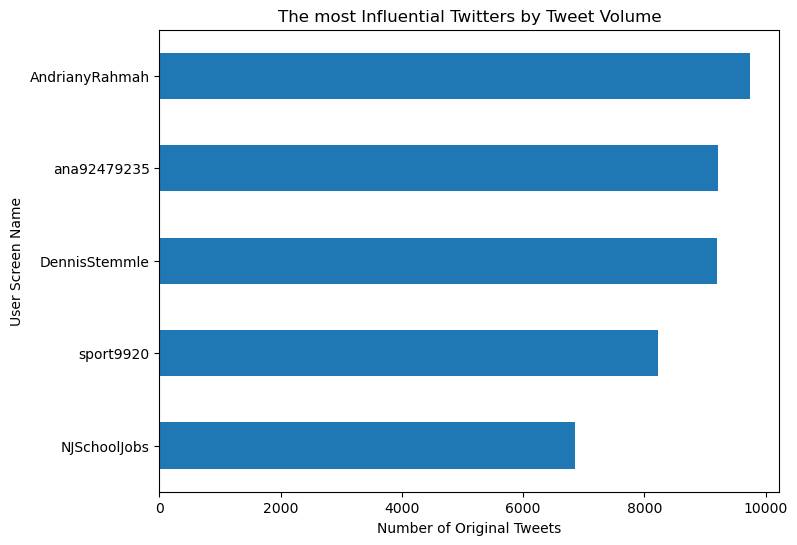

In [43]:
prolific_users_plot = pd_prolific_users.plot(kind='barh',x='user_screen_name', y='original_tweet_count', legend=None, title="The most Influential Twitters by Tweet Volume", figsize=(8, 6))
prolific_users_plot.set_xlabel("Number of Original Tweets")
prolific_users_plot.set_ylabel("User Screen Name")

## Question 1b: Identify the most prolific / influential Twitterers by  message retweet

In [22]:
retweet_df = tweets_filt.select(
            col('user_id'),
            col('user_screen_name'),
            col('tweet_retweeted_status.retweet_count').alias('tweet_retweet_count')
)

In [23]:
retweet_df.limit(5)

user_id,user_screen_name,tweet_retweet_count
42521044,HANOVERxFIST,10589
1110538441899630593,shadowless52,null
2389842944,michilizzle,10590
3325724597,jamaica_sports,null
1546804964797960195,nakroyaaar,null


In [24]:
retweet_df.createOrReplaceTempView("retweet_data")

In [25]:
influential_users = spark.sql(\
                              "SELECT user_id, user_screen_name, avg(tweet_retweet_count) AS Avg_retweet\
                              FROM retweet_data\
                              GROUP BY user_id, user_screen_name\
                              ORDER BY Avg_retweet DESC")

influential_users.show(5)

+-------------------+----------------+-----------+
|            user_id|user_screen_name|Avg_retweet|
+-------------------+----------------+-----------+
| 753350300740706304|  FashionBlock08|   516855.0|
|1208845399777304576|  AlexaLockwood2|   516850.0|
| 869601053284737024|         savvh12|   516795.0|
|1310026646041231361|     TanjeenThat|   516791.0|
|1500356369349849089| CrimsonOmbre115|   516779.0|
+-------------------+----------------+-----------+
only showing top 5 rows



In [26]:
pd_influential_users = influential_users.limit(5).toPandas()
pd_influential_users.head(5)

,user_id,user_screen_name,Avg_retweet
0,753350300740706304,FashionBlock08,516855.0
1,1208845399777304576,AlexaLockwood2,516850.0
2,869601053284737024,savvh12,516795.0
3,1310026646041231361,TanjeenThat,516791.0
4,1500356369349849089,CrimsonOmbre115,516779.0


In [27]:
pd_influential_users = pd_influential_users.iloc[::-1]

Text(0, 0.5, 'User Screen Name')

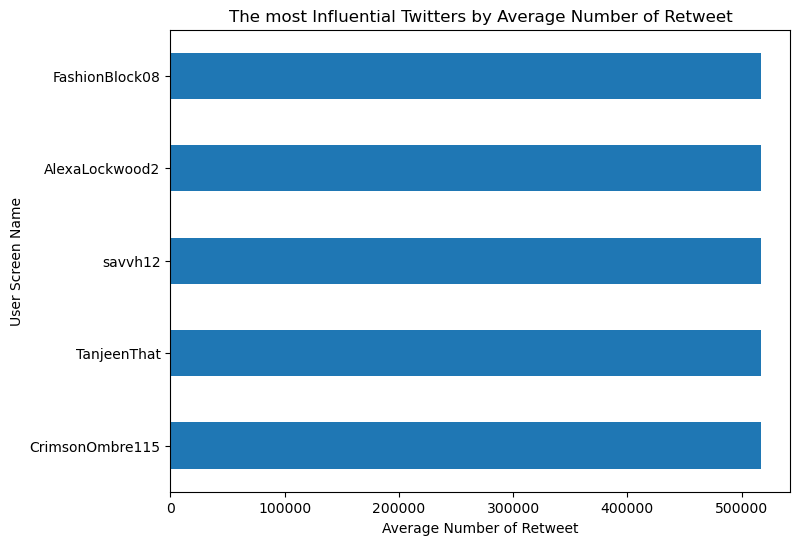

In [42]:
influential_users_plot = pd_influential_users.plot(kind='barh',x='user_screen_name', y='Avg_retweet', legend=None, title="The most Influential Twitters by Average Number of Retweet", figsize=(8, 6))
influential_users_plot.set_xlabel("Average Number of Retweet")
influential_users_plot.set_ylabel("User Screen Name")

## Question 1c: Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)

In [29]:
# List of keywords for each category
is_government = ["government", "gov", "agency", "department", "federal", "state", "local", "white house"]
is_university = ["university", "college", "research", "academy", "school"]
is_school = ["public school", "students", "elementary school", "middle school", "high school"]
is_nonprofit = ["nonprofit", "charity", "foundation", "ngo", "donate"]
is_news = ["news", "journal", "media", "journalist", "reporter", "times", "press", "newspaper", "magazine", "broadcast"]

In [30]:
gov_pattern = "|".join(is_government)
uni_pattern = "|".join(is_university)
sch_pattern = "|".join(is_school)
ngo_pattern = "|".join(is_nonprofit)
news_pattern = "|".join(is_news)

In [31]:
#create a new column that identifies the user based on keywords in the user name and description
modified_tweets = tweets_filt.withColumn("user_category", 
     when(lower(col("user_name")).rlike(gov_pattern) | 
         lower(col("user_description")).rlike(gov_pattern), "Government Entity")
    .when(lower(col("user_name")).rlike(uni_pattern) | 
          lower(col("user_description")).rlike(uni_pattern), "University")
    .when(lower(col("user_name")).rlike(sch_pattern) | 
          lower(col("user_description")).rlike(sch_pattern), "School")                                      
    .when(lower(col("user_name")).rlike(ngo_pattern) | 
          lower(col("user_description")).rlike(ngo_pattern), "Nonprofit Organization")
    .when(lower(col("user_name")).rlike(news_pattern) | 
          lower(col("user_description")).rlike(news_pattern), "News Outlet")
    .when(col("user_followers_count") >= 10000, "Social Media Influencer")
    .otherwise("Someone Else"))

In [32]:
modified_tweets.limit(5)

user_id,user_name,user_screen_name,user_created_at,user_location,user_description,user_verified,user_followers_count,user_friends_count,user_favourites_count,user_statuses_count,tweet_id_str,tweet_created_at,tweet_text,text,tweet_quote_count,tweet_is_quote_status,tweet_timestamp_ms,tweet_retweeted_from,tweet_reply_count,tweet_retweeted_status,tweet_possibly_sensitive,tweet_favorite_count,tweet_location,tweet_city,tweet_coordinates,user_category
42521044,Dr. Henry Killinger,HANOVERxFIST,2009-05-26 00:16:10,Tamriel,King of Suck Ball...,false,176,268,22693,20902,1567874059999887362,2022-09-08 13:54:40,college group pro...,rt hybridoriginal...,0,false,1662645280252,HybridOriginal_,0,"{null, Wed Sep 07...",false,0,null,null,null,Someone Else
1110538441899630593,PM Imran Khan,shadowless52,2019-03-26 13:46:12,🇵🇰Pakistan,How glorious a gr...,false,267,1184,38955,17415,1567874061262266368,2022-09-08 13:54:40,@PakNeuro And the...,pakneuro and the ...,0,false,1662645280553,null,0,null,null,0,null,null,null,Someone Else
2389842944,grape,michilizzle,2014-03-14 21:00:32,South Florida,YHLQMDLG/XO PATRI...,false,1080,920,23723,13043,1567874061778173955,2022-09-08 13:54:40,college group pro...,rt hybridoriginal...,0,false,1662645280676,HybridOriginal_,0,"{null, Wed Sep 07...",false,0,null,null,null,Someone Else
3325724597,All Sports Jamaica,jamaica_sports,2015-06-14 22:35:38,null,Follow us on Inst...,false,147,503,1231,2227,1567874061564317699,2022-09-08 13:54:40,SBF Matchday 1 Zo...,sbf matchday 1 zo...,0,false,1662645280625,ISSASportsJA @Iss...,0,null,false,0,null,null,null,Someone Else
1546804964797960195,mishaaa,nakroyaaar,2022-07-12 10:33:57,"Multan, Pakistan",kesa sama hai,false,31,35,488,506,1567874062776696832,2022-09-08 13:54:40,@sugar_melon_ @ra...,sugar_melon_ rahi...,0,false,1662645280914,rahimanasirr been...,0,null,null,0,null,null,null,Someone Else


In [ ]:
#save the filtered tweet into my bucket in a parquet format for easier loading
modified_tweets.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/mariamoluwatobi/categorised_twitterers')

In [34]:
unique_organization = modified_tweets.dropDuplicates(["user_id"])

In [35]:
unique_organization.count()

11023363

In [36]:
#use the "createOrReplaceTempView" to store my dataframe in order to run SparkSQL statements against the data
unique_organization.createOrReplaceTempView("unique_data")

In [37]:
twitterers_description = spark.sql(\
                              "SELECT user_category, count(*) AS total_twitterers\
                              FROM unique_data\
                              GROUP BY user_category\
                              ORDER BY total_twitterers DESC")

In [38]:
pd_twitterers_description = twitterers_description.limit(100).toPandas()
pd_twitterers_description.head(10)

,user_category,total_twitterers
0,Someone Else,9760162
1,University,479131
2,News Outlet,326442
3,Government Entity,231351
4,Social Media Influencer,150409
5,Nonprofit Organization,59008
6,School,16860


In [39]:
pd_twitterers_description = pd_twitterers_description.iloc[::-1]

Text(0, 0.5, 'The User Category')

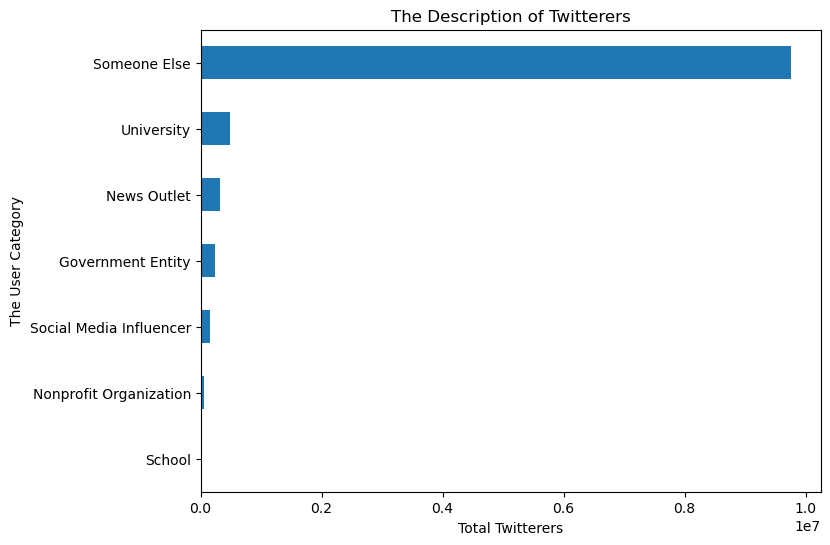

In [41]:
twitterers_description_plot = pd_twitterers_description.plot(kind='barh',x='user_category', y='total_twitterers', legend=None, title="The Description of Twitterers", figsize=(8, 6))
twitterers_description_plot.set_xlabel("Total Twitterers")
twitterers_description_plot.set_ylabel("The User Category")

## Question 1d: Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

### Distribution of tweet by Twitterers and types of organizations

In [44]:
#use the "createOrReplaceTempView" to store my dataframe in order to run SparkSQL statements against the data
modified_tweets.createOrReplaceTempView("modified_data")

In [45]:
organization_distribution = spark.sql(\
                              "SELECT user_category, count(*) AS total_tweets\
                              FROM modified_data\
                              GROUP BY user_category\
                              ORDER BY total_tweets DESC")

In [49]:
pd_organization_distribution = organization_distribution.limit(10).toPandas()
pd_organization_distribution.head(10)

,user_category,total_tweets
0,Someone Else,29954803
1,University,2501457
2,News Outlet,1626260
3,Government Entity,1129727
4,Social Media Influencer,1080789
5,Nonprofit Organization,207936
6,School,99102


In [47]:
pd_organization_distribution = pd_organization_distribution.iloc[::-1]

Text(0, 0.5, 'Type of Organization')

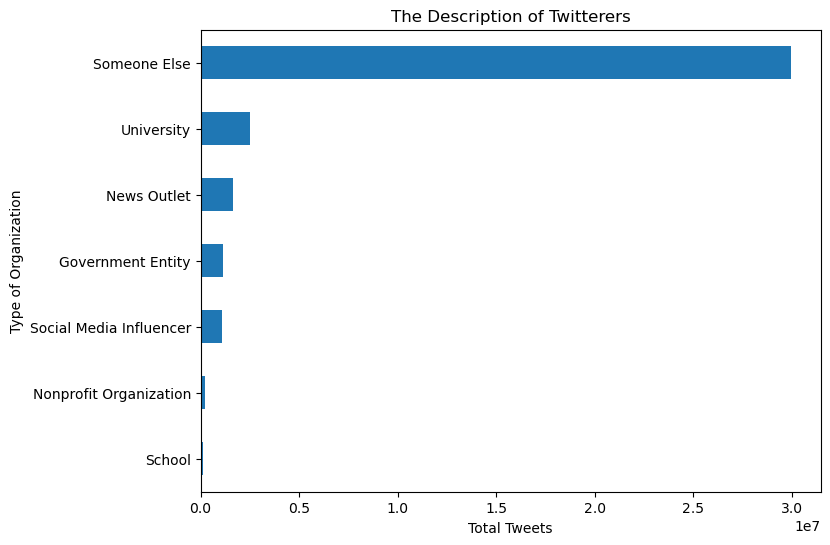

In [48]:
organization_distribution_plot = pd_organization_distribution.plot(kind='barh',x='user_category', y='total_tweets', legend=None, title="The Description of Twitterers", figsize=(8, 6))
organization_distribution_plot.set_xlabel("Total Tweets")
organization_distribution_plot.set_ylabel("Type of Organization")

### Distribution of retweet by Twitters and types of organization

In [50]:
modified_df = modified_tweets.select(
            col('user_id'),
            col('user_screen_name'),
            col('user_category'),
            col('tweet_retweeted_status.retweet_count').alias('tweet_retweet_count')
)

In [51]:
#use the "createOrReplaceTempView" to store my dataframe in order to run SparkSQL statements against the data
modified_df.createOrReplaceTempView("modified_category")

In [52]:
organization_distribution2 = spark.sql(\
                          "SELECT user_category, avg(tweet_retweet_count) AS Avg_retweet\
                           FROM modified_category\
                           GROUP BY user_category\
                           ORDER BY Avg_retweet DESC")

In [53]:
pd_organization_distribution2 = organization_distribution2.toPandas()
pd_organization_distribution2.head(7)

,user_category,Avg_retweet
0,Someone Else,2201.204698
1,Nonprofit Organization,1679.104819
2,News Outlet,1520.477184
3,Government Entity,1122.648605
4,Social Media Influencer,955.182815
5,University,580.625220
6,School,269.752437


In [54]:
pd_organization_distribution2 = pd_organization_distribution2.iloc[::-1]

Text(0, 0.5, 'Type of Organization')

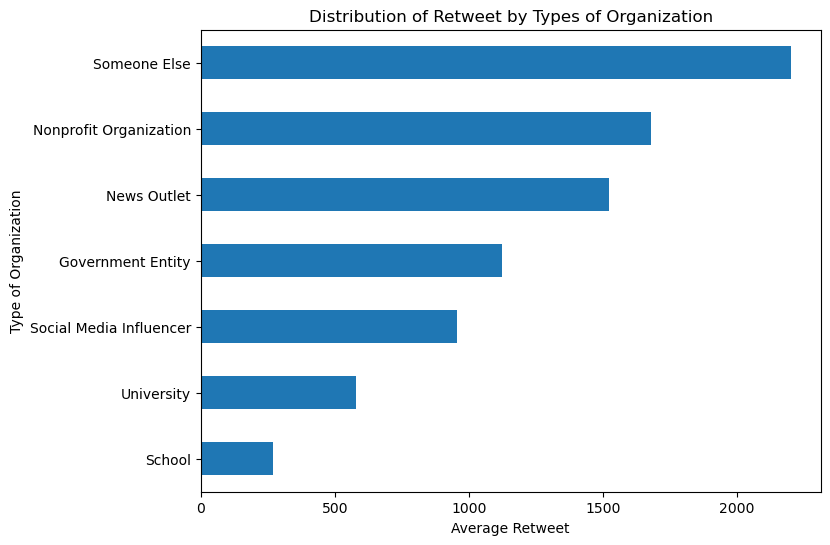

In [55]:
# Create a bar plot
pd_organization_distribution2_plot = pd_organization_distribution2.plot(kind='barh',x='user_category', y='Avg_retweet', legend=None, title="Distribution of Retweet by Types of Organization", figsize=(8, 6))
pd_organization_distribution2_plot.set_xlabel("Average Retweet")
pd_organization_distribution2_plot.set_ylabel("Type of Organization")

## Further analysis to get the category of the twitters

In [ ]:
user_screen_name = "sport9920"
user_category = modified_tweets.filter(modified_tweets.user_name == user_screen_name).select("user_category").collect()[0][0]
print("User category for {} is {}".format(user_screen_name, user_category))

## Q1a

In [56]:
#identify the most prolific users by original tweet volume
prolific_users2 = modified_tweets.groupby(col("user_id"), col("user_screen_name"), col("user_category")).agg(count("*").alias("original_tweet_count"))

In [57]:
#sort the data in descending order
sorted_original_tweet2 = prolific_users2.sort(col("original_tweet_count").desc())

sorted_original_tweet2.show(10)

+-------------------+----------------+-------------+--------------------+
|            user_id|user_screen_name|user_category|original_tweet_count|
+-------------------+----------------+-------------+--------------------+
|1128225338775953408|  AndrianyRahmah|  News Outlet|                9741|
|          219401992|   DennisStemmle|   University|                9194|
|1463182041147576321|       sport9920| Someone Else|                8227|
|           66263683|    NJSchoolJobs|   University|                6886|
|1576939116230455296|    dini92276801| Someone Else|                6721|
|1577029442488061953|        TeriWini| Someone Else|                6560|
|1422259384525090818|     ana92479235|   University|                6506|
| 879496394691805184|    EssayPaperUK| Someone Else|                6249|
|1295715136141963267|  education_24x7| Someone Else|                6229|
|1582053513357537293|       qiopalika| Someone Else|                6197|
+-------------------+----------------+

## Q1b

In [58]:
modified_df2 = modified_tweets.select(
            col('user_id'),
            col('user_screen_name'),
            col('user_category'),
            col('tweet_retweeted_status.retweet_count').alias('tweet_retweet_count')
)

In [59]:
#use the "createOrReplaceTempView" to store my dataframe in order to run SparkSQL statements against the data
modified_df2.createOrReplaceTempView("modified_data2")

In [ ]:
influential_users2 = spark.sql(\
                              "SELECT user_id, user_screen_name, user_category, avg(tweet_retweet_count) AS Avg_retweet\
                              FROM modified_data2\
                              GROUP BY user_id, user_screen_name, user_category\
                              ORDER BY Avg_retweet DESC")

influential_users2.show(10)

+-------------------+----------------+-------------+-----------+
|            user_id|user_screen_name|user_category|Avg_retweet|
+-------------------+----------------+-------------+-----------+
| 753350300740706304|  FashionBlock08| Someone Else|   516855.0|
|1208845399777304576|  AlexaLockwood2| Someone Else|   516850.0|
| 869601053284737024|         savvh12| Someone Else|   516795.0|
|1310026646041231361|     TanjeenThat| Someone Else|   516791.0|
|1500356369349849089| CrimsonOmbre115| Someone Else|   516779.0|
|1472773509852008451|   Raeemonique11| Someone Else|   516772.0|
|1332816632314355713|      Boi0Winter| Someone Else|   516711.0|
|         2459668231|    Dudesphootos| Someone Else|   516635.0|
|1292284502304329736|   Beefstarters3| Someone Else|   516593.0|
|1402518068279091200|   Riley42376368| Someone Else|   516570.0|
+-------------------+----------------+-------------+-----------+
only showing top 10 rows

